### Experimentation Notebook

In [8]:
# Load data

import numpy
import pandas as pd

df = pd.read_csv("../data/people_data.csv")

df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [30]:
# Display values by age

pd.set_option('display.max_rows', None)
df['age'].value_counts(sort=True, ascending=False)

age
26     2197
1      1123
28      918
35      880
24      859
25      734
30      724
32      664
27      615
29      570
40      526
36      483
2       482
45      440
23      426
34      409
22      395
50      381
54      353
31      350
21      346
38      325
37      293
60      293
3       289
20      284
4       273
58      271
55      268
42      266
39      265
8       263
18      262
65      259
16      247
53      241
56      236
52      232
5       196
15      177
47      170
9       166
61      159
17      158
14      157
43      157
10      156
85      155
46      153
48      153
75      148
49      148
70      147
33      143
7       139
51      138
80      133
41      132
6       131
12      130
62      125
63      103
68      100
44      100
19       98
72       98
57       97
67       94
59       82
90       82
13       81
66       77
78       69
11       65
73       63
76       58
69       56
64       50
82       40
86       35
88       34
71       33
89       33


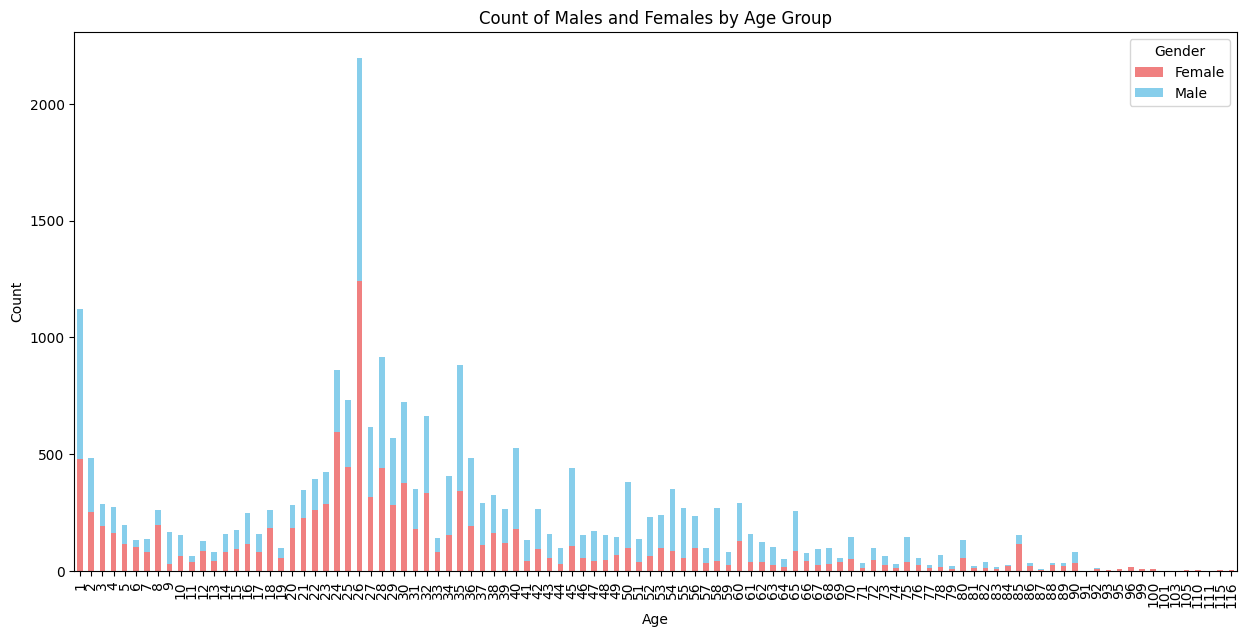

In [37]:
# Show male and female count by age

import matplotlib.pyplot as plt

df['gender'] = df['gender'].replace({0: 'Male', 1: 'Female'})
count_plot = df.groupby(['age', 'gender']).size().unstack(fill_value=0)
count_plot.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], figsize=(15, 7))

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of Males and Females by Age Group')
plt.legend(title='Gender')

plt.show()

